In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
from train import get_args
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    

/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## Flows are coded as (x, y) where +y is upward in the image; value is in pixels

In [4]:
chairs_dataset = raft_datasets.FlyingChairs(
    root='../datasets/FlyingChairs_release/data',
    split='validation', 
    split_file='../chairs_split.txt')
print(len(chairs_dataset))
img1, img2, flow, valid = chairs_dataset[0]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


640


In [78]:
from bootraft import BootRaft
args = set_args()
net = torch.nn.DataParallel(RAFT(args))
# net = torch.nn.DataParallel(BootRaft(args))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
ls ../checkpoints/raft-tdw-long.pth

../checkpoints/raft-tdw-long.pth


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
load_path = '../checkpoints/raft-tdw-bn.pth'
# load_path = '../models/raft-sintel.pth'
net.load_state_dict(torch.load(load_path), strict=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>

In [80]:
net.cuda()
net.eval()
net.module.freeze_bn()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
#     root='/mnt/fs5/dbear/tdw_datasets/primitives_large_v1/',
#     root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
    dataset_names=['model_split_4'],    
#     dataset_names=['model_split_%d' % split for split in range(32)],
    split='validation',
    filepattern="*",
    test_filepattern="0*[0-4]",
    min_start_frame=5,
    max_start_frame=None,
    scale_to_pixels=True,
    get_gt_flow=True,
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


500
True


In [10]:
def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24]):
    dataset.is_test = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    img1, img2, gt, _ = dataset[ex]
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        pred = flow_viz.flow_to_image(tensor_to_arr(pred))
        preds.append(pred)
    _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(1,2 + len(iters),figsize=(8 + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + ['gt']
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


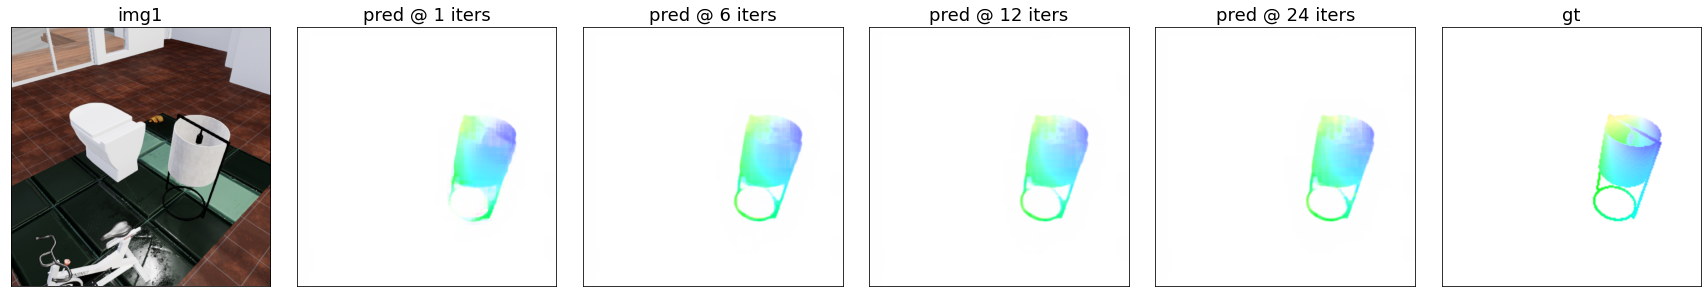

In [90]:
viz_raft_prediction(net, tdw_dataset, ex=41, iters=[1,6,12,24])

In [12]:
def normalize(img):
    return 2.0 * (img / 255.) - 1.0
img1, img2, flow, _ = tdw_dataset[1]
# fmap1, fmap2 = net.module.fnet([normalize(img1[None].cuda()), normalize(img2[None].cuda())])
# ctx = net.module.cnet(img1[None].cuda())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
from tqdm import tqdm
DEFAULT_CMAP = plt.cm.twilight
DEFAULT_ERRMAP_COLORS = {k:float(v)/DEFAULT_CMAP.N for k,v in {'tp': 250, 'tn': 0, 'fp': 420, 'fn': 80}.items()}

def plot_errormap(model, dataset, ex=None, iters=24, thresh=4, 
                  cmap=DEFAULT_CMAP,
                  colors=DEFAULT_ERRMAP_COLORS,
                  do_plot=True,
                  return_errormap=True,
                  return_images=False,
                 ):
    if ex is None:
        ex = np.random.randint(len(dataset))
    img1, img2, flow = dataset[ex][:3]
    _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=iters, test_mode=True)
    
    _seg = lambda x, t: (x.square().sum(-3).sqrt() > t).cpu().numpy()[0]
    pred_seg = _seg(pred, thresh)
    gt_seg = _seg(flow[None], 0.5)
    
    tp = pred_seg & gt_seg
    tn = ~pred_seg & ~gt_seg
    fp = pred_seg & ~gt_seg
    fn = ~pred_seg & gt_seg
    n = (pred_seg | gt_seg).sum() + 0.
    
    metrics = {
        'iou': tp.sum() / n,
        'precision': (tp.sum() + 0.) / (tp.sum() + fp.sum()),
        'recall': (tp.sum() + 0.) / (tp.sum() + fn.sum())
    }

    errmap = np.zeros(list(gt_seg.shape) + [3])
    errmap[pred_seg & gt_seg] = list(cmap(colors['tp']))[:3]
    errmap[~pred_seg & ~gt_seg] = list(cmap(colors['tn']))[:3]
    errmap[pred_seg & ~gt_seg] = list(cmap(colors['fp']))[:3]
    errmap[~pred_seg & gt_seg] = list(cmap(colors['fn']))[:3]
    
    if do_plot:
        plt.imshow(errmap)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    elif return_errormap:
        metrics['error_map'] = errmap
        
    if return_images:
        metrics.update({
            'image1': img1.permute(1, 2, 0).cpu().numpy() / 255.,
            'image2': img2.permute(1, 2, 0).cpu().numpy() / 255.,
            'pred': flow_viz.flow_to_image(tensor_to_arr(pred[0])),
            'gt': flow_viz.flow_to_image(tensor_to_arr(flow))
        })
    
    return metrics

def visualize_error_maps(model, dataset, examples=[0], iters=24, thresh=4, max_examples=5):
    
    def val_fn(ex):
        metrics = plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, 
                                do_plot=False, return_errormap=True, return_images=True)
        return metrics
    
    if examples is None:
        examples = [np.random.randint(len(dataset)) for _ in range(max_examples)]
    elif isinstance(examples, int):
        examples = [examples]
    else:
        examples = examples[:max_examples]
        
    titles = ['image1', 'gt', 'pred @ %d iters' % iters, 'iou = ']
    n_rows = min(len(examples), max_examples)
    n_cols = len(titles)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    
    for row, ex in enumerate(examples):
        return_vals = val_fn(ex)
        ax = axes[row]
        ax[0].imshow(return_vals['image1'])
        ax[1].imshow(return_vals['gt'])
        ax[2].imshow(return_vals['pred'])
        ax[3].imshow(return_vals['error_map'])
        
        iou = return_vals['iou']
        ts = titles[:3] + [titles[-1] + ("%.3f" % iou)]
        for col, title in enumerate(ts):
            if col == 3:
                ax[col].set_title(ts[col], fontsize=18, y=0.92)
            ax[col].set_xticks([])
            ax[col].set_yticks([])
        
    plt.tight_layout()
    plt.show()


def validate_examples(model, dataset, examples=[0], iters=24, thresh=4):
    
    def val_fn(ex):
        return plot_errormap(model, dataset, ex=ex, iters=iters, thresh=thresh, do_plot=False, return_errormap=False)
    
    if examples is None:
        examples = range(len(dataset))
    elif isinstance(examples, int):
        examples = [examples]
    
    metrics = {'iou': [], 'precision': [], 'recall': []}
    for ex in tqdm(examples):
        m = val_fn(ex)
        for k,v in m.items():
            metrics[k].append(v)
    return metrics

def agg_metrics(metrics):
    agg = {k:np.nanmean(np.array(v)) for k,v in metrics.items()}
    nans = {k+'_isnan':np.isnan(np.array(v)).mean() for k,v in metrics.items()}
    return (agg, nans)
    

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
print(load_path)

../checkpoints/raft-tdw-bn.pth


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


selected frame 4
selected frame 9
selected frame 14
selected frame 21
selected frame 11


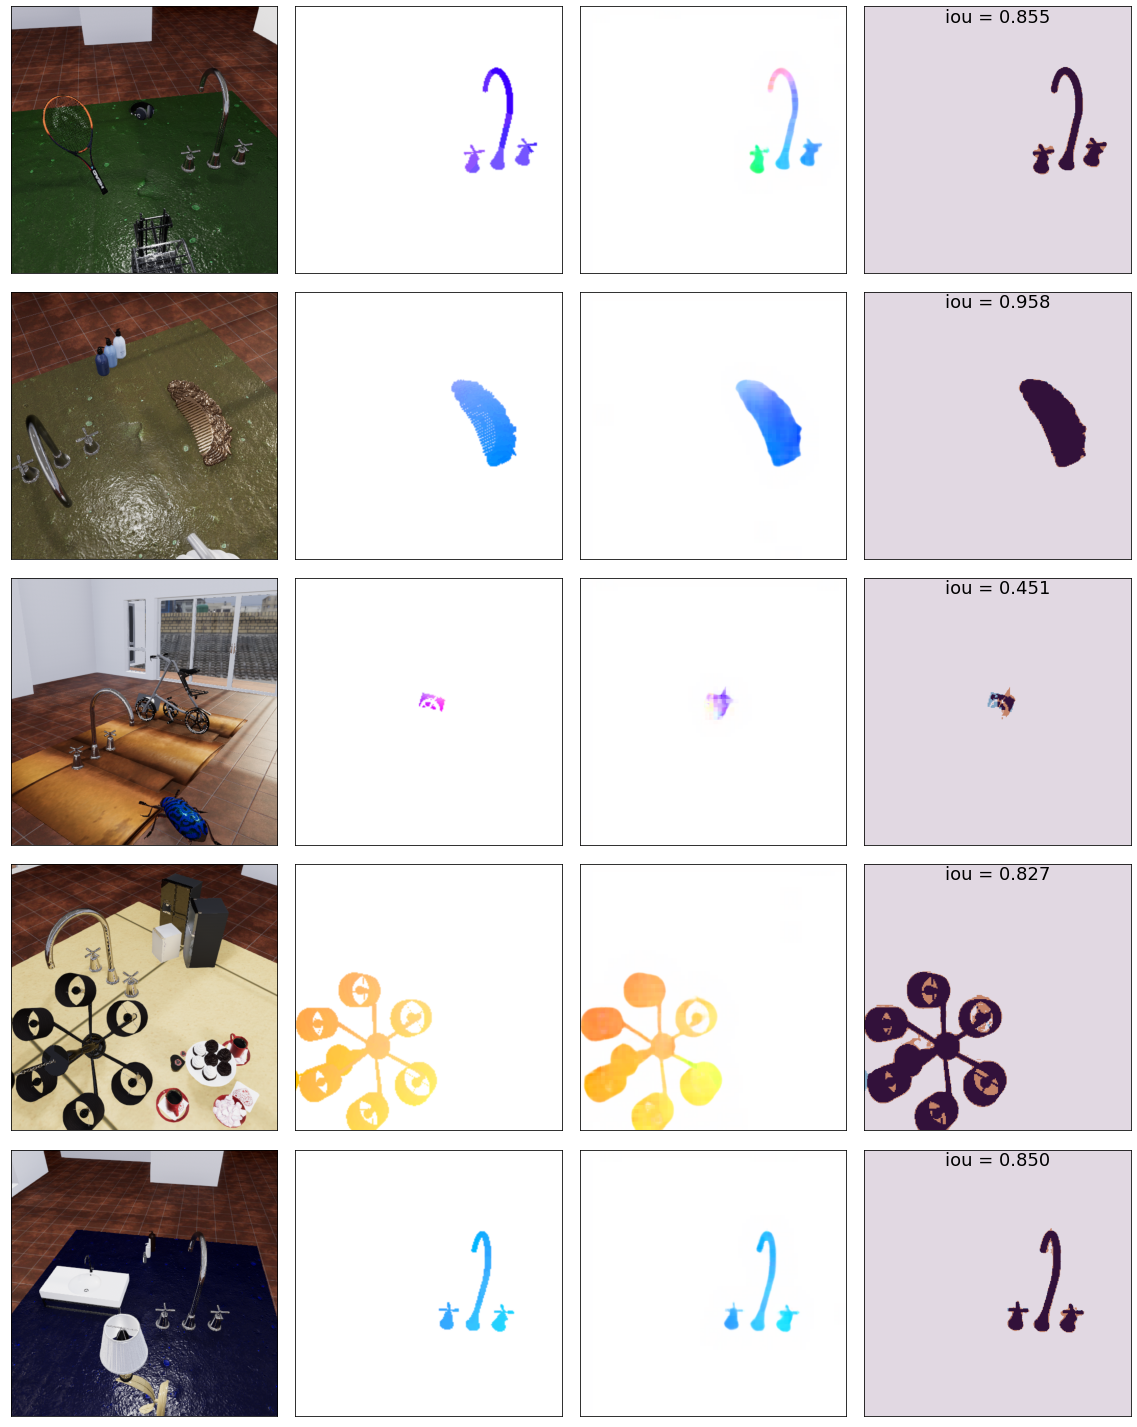

In [128]:
tdw_dataset.is_test = False
visualize_error_maps(net, tdw_dataset, examples=range(5), thresh=0.5)

In [129]:
tdw_dataset.is_test = True
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=0.5, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

selected frame 4


  0%|          | 1/500 [00:00<02:25,  3.42it/s]

selected frame 9


  0%|          | 2/500 [00:00<02:12,  3.76it/s]

selected frame 14


  1%|          | 3/500 [00:00<02:05,  3.96it/s]

selected frame 21


  1%|          | 4/500 [00:01<02:00,  4.12it/s]

selected frame 11


  1%|          | 5/500 [00:01<01:58,  4.19it/s]

selected frame 44


  1%|          | 6/500 [00:01<01:56,  4.25it/s]

selected frame 7


  1%|▏         | 7/500 [00:01<02:00,  4.08it/s]

selected frame 14


  2%|▏         | 8/500 [00:01<01:57,  4.18it/s]

selected frame 119


  2%|▏         | 9/500 [00:02<01:59,  4.10it/s]

selected frame 6


  2%|▏         | 10/500 [00:02<02:04,  3.94it/s]

selected frame 126


  2%|▏         | 11/500 [00:02<02:07,  3.84it/s]

selected frame 11


  2%|▏         | 12/500 [00:03<02:12,  3.68it/s]

selected frame 45


  3%|▎         | 13/500 [00:03<02:09,  3.76it/s]

selected frame 4


  3%|▎         | 14/500 [00:03<02:09,  3.76it/s]

selected frame 29


  3%|▎         | 15/500 [00:03<02:12,  3.66it/s]

selected frame 52


  3%|▎         | 16/500 [00:04<02:08,  3.76it/s]

selected frame 17


  3%|▎         | 17/500 [00:04<02:10,  3.69it/s]

selected frame 18


  4%|▎         | 18/500 [00:04<02:08,  3.75it/s]

selected frame 14


  4%|▍         | 19/500 [00:04<02:04,  3.86it/s]

selected frame 52


  4%|▍         | 20/500 [00:05<02:12,  3.62it/s]

selected frame 38


  4%|▍         | 21/500 [00:05<02:07,  3.75it/s]

selected frame 4


  4%|▍         | 22/500 [00:05<02:06,  3.79it/s]

selected frame 13


  5%|▍         | 23/500 [00:05<02:00,  3.97it/s]

selected frame 8


  5%|▍         | 24/500 [00:06<02:01,  3.91it/s]

selected frame 4


  5%|▌         | 25/500 [00:06<01:57,  4.03it/s]

selected frame 45


  5%|▌         | 26/500 [00:06<01:54,  4.14it/s]

selected frame 42


  5%|▌         | 27/500 [00:06<01:53,  4.16it/s]

selected frame 48


  6%|▌         | 28/500 [00:07<01:54,  4.11it/s]

selected frame 4


  6%|▌         | 29/500 [00:07<01:57,  4.02it/s]

selected frame 42


  6%|▌         | 30/500 [00:07<01:55,  4.08it/s]

selected frame 74


  6%|▌         | 31/500 [00:07<01:53,  4.14it/s]

selected frame 8


  6%|▋         | 32/500 [00:08<01:52,  4.17it/s]

selected frame 20


  7%|▋         | 33/500 [00:08<01:51,  4.20it/s]

selected frame 4


  7%|▋         | 34/500 [00:08<01:51,  4.17it/s]

selected frame 46


  7%|▋         | 35/500 [00:08<02:02,  3.79it/s]

selected frame 0


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
  7%|▋         | 36/500 [00:09<02:04,  3.72it/s]

selected frame 2


  7%|▋         | 37/500 [00:09<02:02,  3.79it/s]

selected frame 8


  8%|▊         | 38/500 [00:09<01:58,  3.91it/s]

selected frame 12


  8%|▊         | 39/500 [00:09<02:03,  3.75it/s]

selected frame 6


  8%|▊         | 40/500 [00:10<01:59,  3.85it/s]

selected frame 4


  8%|▊         | 41/500 [00:10<01:54,  4.02it/s]

selected frame 59


  8%|▊         | 42/500 [00:10<02:02,  3.74it/s]

selected frame 43


  9%|▊         | 43/500 [00:11<02:04,  3.67it/s]

selected frame 6


  9%|▉         | 44/500 [00:11<02:00,  3.78it/s]

selected frame 6


  9%|▉         | 45/500 [00:11<02:08,  3.55it/s]

selected frame 47


  9%|▉         | 46/500 [00:11<02:02,  3.72it/s]

selected frame 15


  9%|▉         | 47/500 [00:12<02:02,  3.70it/s]

selected frame 8


 10%|▉         | 48/500 [00:12<01:58,  3.81it/s]

selected frame 4


 10%|▉         | 49/500 [00:12<01:58,  3.82it/s]

selected frame 52


 10%|█         | 50/500 [00:12<01:56,  3.87it/s]

selected frame 34


 10%|█         | 51/500 [00:13<01:58,  3.78it/s]

selected frame 17


 10%|█         | 52/500 [00:13<01:56,  3.84it/s]

selected frame 5


 11%|█         | 53/500 [00:13<01:55,  3.87it/s]

selected frame 12


 11%|█         | 54/500 [00:13<01:50,  4.02it/s]

selected frame 6


 11%|█         | 55/500 [00:14<01:46,  4.16it/s]

selected frame 29


 11%|█         | 56/500 [00:14<01:46,  4.19it/s]

selected frame 0


 11%|█▏        | 57/500 [00:14<01:47,  4.10it/s]

selected frame 0


 12%|█▏        | 58/500 [00:14<01:48,  4.08it/s]

selected frame 16


 12%|█▏        | 59/500 [00:15<01:44,  4.23it/s]

selected frame 74


 12%|█▏        | 60/500 [00:15<01:55,  3.81it/s]

selected frame 15


 12%|█▏        | 61/500 [00:15<01:56,  3.78it/s]

selected frame 20


 12%|█▏        | 62/500 [00:15<01:54,  3.83it/s]

selected frame 25


 13%|█▎        | 63/500 [00:16<01:51,  3.92it/s]

selected frame 4


 13%|█▎        | 64/500 [00:16<01:56,  3.73it/s]

selected frame 3


 13%|█▎        | 65/500 [00:16<01:52,  3.86it/s]

selected frame 33


 13%|█▎        | 66/500 [00:16<01:48,  4.01it/s]

selected frame 21


 13%|█▎        | 67/500 [00:17<01:49,  3.97it/s]

selected frame 93


 14%|█▎        | 68/500 [00:17<01:56,  3.72it/s]

selected frame 4


 14%|█▍        | 69/500 [00:17<01:52,  3.82it/s]

selected frame 84


 14%|█▍        | 70/500 [00:17<01:47,  4.00it/s]

selected frame 15


 14%|█▍        | 71/500 [00:18<01:48,  3.96it/s]

selected frame 5


 14%|█▍        | 72/500 [00:18<01:46,  4.01it/s]

selected frame 0


 15%|█▍        | 73/500 [00:18<01:48,  3.92it/s]

selected frame 21


 15%|█▍        | 74/500 [00:18<01:51,  3.83it/s]

selected frame 88


 15%|█▌        | 75/500 [00:19<01:50,  3.86it/s]

selected frame 14


 15%|█▌        | 76/500 [00:19<01:48,  3.90it/s]

selected frame 26


 15%|█▌        | 77/500 [00:19<01:48,  3.90it/s]

selected frame 7


 16%|█▌        | 78/500 [00:20<01:53,  3.73it/s]

selected frame 65


 16%|█▌        | 79/500 [00:20<01:47,  3.92it/s]

selected frame 61


 16%|█▌        | 80/500 [00:20<01:43,  4.06it/s]

selected frame 12


 16%|█▌        | 81/500 [00:20<01:42,  4.08it/s]

selected frame 19


 16%|█▋        | 82/500 [00:20<01:40,  4.17it/s]

selected frame 7


 17%|█▋        | 83/500 [00:21<01:38,  4.25it/s]

selected frame 40


 17%|█▋        | 84/500 [00:21<01:38,  4.23it/s]

selected frame 8


 17%|█▋        | 85/500 [00:21<01:34,  4.38it/s]

selected frame 0


 17%|█▋        | 86/500 [00:21<01:40,  4.12it/s]

selected frame 23


 17%|█▋        | 87/500 [00:22<01:39,  4.16it/s]

selected frame 4


 18%|█▊        | 88/500 [00:22<01:42,  4.03it/s]

selected frame 31


 18%|█▊        | 89/500 [00:22<01:48,  3.77it/s]

selected frame 19


 18%|█▊        | 90/500 [00:22<01:43,  3.95it/s]

selected frame 19


 18%|█▊        | 91/500 [00:23<01:46,  3.84it/s]

selected frame 3


 18%|█▊        | 92/500 [00:23<01:44,  3.91it/s]

selected frame 44


 19%|█▊        | 93/500 [00:23<01:43,  3.94it/s]

selected frame 27


 19%|█▉        | 94/500 [00:23<01:45,  3.84it/s]

selected frame 4


 19%|█▉        | 95/500 [00:24<01:44,  3.86it/s]

selected frame 19


 19%|█▉        | 96/500 [00:24<01:45,  3.84it/s]

selected frame 11


 19%|█▉        | 97/500 [00:24<01:41,  3.95it/s]

selected frame 10


 20%|█▉        | 98/500 [00:24<01:41,  3.96it/s]

selected frame 0


 20%|█▉        | 99/500 [00:25<01:49,  3.66it/s]

selected frame 6


 20%|██        | 100/500 [00:25<01:43,  3.85it/s]

selected frame 5


 20%|██        | 101/500 [00:25<01:41,  3.95it/s]

selected frame 33


 20%|██        | 102/500 [00:26<01:39,  4.00it/s]

selected frame 0


 21%|██        | 103/500 [00:26<01:37,  4.06it/s]

selected frame 4


 21%|██        | 104/500 [00:26<01:38,  4.02it/s]

selected frame 3


 21%|██        | 105/500 [00:26<01:38,  4.00it/s]

selected frame 60


 21%|██        | 106/500 [00:27<01:35,  4.11it/s]

selected frame 19


 21%|██▏       | 107/500 [00:27<01:35,  4.11it/s]

selected frame 24


 22%|██▏       | 108/500 [00:27<01:34,  4.13it/s]

selected frame 50


 22%|██▏       | 109/500 [00:27<01:34,  4.14it/s]

selected frame 0


 22%|██▏       | 110/500 [00:28<01:38,  3.96it/s]

selected frame 30


 22%|██▏       | 111/500 [00:28<01:37,  3.98it/s]

selected frame 9


 22%|██▏       | 112/500 [00:28<01:39,  3.88it/s]

selected frame 32


 23%|██▎       | 113/500 [00:28<01:36,  4.02it/s]

selected frame 4


 23%|██▎       | 114/500 [00:28<01:35,  4.05it/s]

selected frame 4


 23%|██▎       | 115/500 [00:29<01:42,  3.76it/s]

selected frame 19


 23%|██▎       | 116/500 [00:29<01:39,  3.86it/s]

selected frame 14


 23%|██▎       | 117/500 [00:29<01:35,  4.02it/s]

selected frame 15


 24%|██▎       | 118/500 [00:30<01:36,  3.97it/s]

selected frame 19


 24%|██▍       | 119/500 [00:30<01:34,  4.03it/s]

selected frame 4


 24%|██▍       | 120/500 [00:30<01:35,  3.99it/s]

selected frame 25


 24%|██▍       | 121/500 [00:30<01:35,  3.98it/s]

selected frame 4


 24%|██▍       | 122/500 [00:31<01:33,  4.03it/s]

selected frame 36


 25%|██▍       | 123/500 [00:31<01:32,  4.06it/s]

selected frame 4


 25%|██▍       | 124/500 [00:31<01:39,  3.78it/s]

selected frame 13


 25%|██▌       | 125/500 [00:31<01:36,  3.88it/s]

selected frame 58


 25%|██▌       | 126/500 [00:32<01:34,  3.96it/s]

selected frame 12


 25%|██▌       | 127/500 [00:32<01:34,  3.96it/s]

selected frame 4


 26%|██▌       | 128/500 [00:32<01:32,  4.01it/s]

selected frame 27


 26%|██▌       | 129/500 [00:32<01:36,  3.85it/s]

selected frame 47


 26%|██▌       | 130/500 [00:33<01:41,  3.64it/s]

selected frame 53


 26%|██▌       | 131/500 [00:33<01:40,  3.66it/s]

selected frame 20


 26%|██▋       | 132/500 [00:33<01:35,  3.85it/s]

selected frame 0


 27%|██▋       | 133/500 [00:33<01:34,  3.90it/s]

selected frame 4


 27%|██▋       | 134/500 [00:34<01:33,  3.91it/s]

selected frame 6


 27%|██▋       | 135/500 [00:34<01:30,  4.03it/s]

selected frame 20


 27%|██▋       | 136/500 [00:34<01:27,  4.15it/s]

selected frame 4


 27%|██▋       | 137/500 [00:34<01:33,  3.90it/s]

selected frame 3


 28%|██▊       | 138/500 [00:35<01:30,  4.00it/s]

selected frame 117


 28%|██▊       | 139/500 [00:35<01:28,  4.06it/s]

selected frame 28


 28%|██▊       | 140/500 [00:35<01:31,  3.92it/s]

selected frame 5


 28%|██▊       | 141/500 [00:35<01:33,  3.85it/s]

selected frame 22


 28%|██▊       | 142/500 [00:36<01:29,  4.00it/s]

selected frame 40


 29%|██▊       | 143/500 [00:36<01:27,  4.09it/s]

selected frame 19


 29%|██▉       | 144/500 [00:36<01:26,  4.11it/s]

selected frame 36


 29%|██▉       | 145/500 [00:36<01:25,  4.16it/s]

selected frame 22


 29%|██▉       | 146/500 [00:37<01:22,  4.29it/s]

selected frame 39


 29%|██▉       | 147/500 [00:37<01:19,  4.43it/s]

selected frame 8


 30%|██▉       | 148/500 [00:37<01:23,  4.23it/s]

selected frame 84


 30%|██▉       | 149/500 [00:37<01:25,  4.10it/s]

selected frame 48


 30%|███       | 150/500 [00:38<01:26,  4.05it/s]

selected frame 34


 30%|███       | 151/500 [00:38<01:25,  4.06it/s]

selected frame 5


 30%|███       | 152/500 [00:38<01:27,  3.96it/s]

selected frame 28


 31%|███       | 153/500 [00:38<01:31,  3.79it/s]

selected frame 4


 31%|███       | 154/500 [00:39<01:27,  3.94it/s]

selected frame 2


 31%|███       | 155/500 [00:39<01:31,  3.77it/s]

selected frame 7


 31%|███       | 156/500 [00:39<01:29,  3.85it/s]

selected frame 0


 31%|███▏      | 157/500 [00:39<01:29,  3.83it/s]

selected frame 17


 32%|███▏      | 158/500 [00:40<01:24,  4.04it/s]

selected frame 14


 32%|███▏      | 159/500 [00:40<01:24,  4.02it/s]

selected frame 63


 32%|███▏      | 160/500 [00:40<01:24,  4.04it/s]

selected frame 12


 32%|███▏      | 161/500 [00:40<01:24,  4.03it/s]

selected frame 4


 32%|███▏      | 162/500 [00:41<01:23,  4.06it/s]

selected frame 125


 33%|███▎      | 163/500 [00:41<01:24,  4.01it/s]

selected frame 18


 33%|███▎      | 164/500 [00:41<01:23,  4.04it/s]

selected frame 61


 33%|███▎      | 165/500 [00:41<01:23,  4.03it/s]

selected frame 7


 33%|███▎      | 166/500 [00:42<01:23,  4.02it/s]

selected frame 2


 33%|███▎      | 167/500 [00:42<01:22,  4.04it/s]

selected frame 6


 34%|███▎      | 168/500 [00:42<01:20,  4.13it/s]

selected frame 3


 34%|███▍      | 169/500 [00:42<01:21,  4.08it/s]

selected frame 28


 34%|███▍      | 170/500 [00:43<01:20,  4.12it/s]

selected frame 4


 34%|███▍      | 171/500 [00:43<01:19,  4.15it/s]

selected frame 23


 34%|███▍      | 172/500 [00:43<01:18,  4.16it/s]

selected frame 0


 35%|███▍      | 173/500 [00:43<01:19,  4.14it/s]

selected frame 6


 35%|███▍      | 174/500 [00:43<01:17,  4.20it/s]

selected frame 13


 35%|███▌      | 175/500 [00:44<01:16,  4.25it/s]

selected frame 64


 35%|███▌      | 176/500 [00:44<01:15,  4.31it/s]

selected frame 16


 35%|███▌      | 177/500 [00:44<01:16,  4.23it/s]

selected frame 83


 36%|███▌      | 178/500 [00:44<01:15,  4.24it/s]

selected frame 76


 36%|███▌      | 179/500 [00:45<01:16,  4.19it/s]

selected frame 50


 36%|███▌      | 180/500 [00:45<01:14,  4.28it/s]

selected frame 99


 36%|███▌      | 181/500 [00:45<01:15,  4.25it/s]

selected frame 0


 36%|███▋      | 182/500 [00:45<01:17,  4.12it/s]

selected frame 34


 37%|███▋      | 183/500 [00:46<01:17,  4.07it/s]

selected frame 5


 37%|███▋      | 184/500 [00:46<01:17,  4.07it/s]

selected frame 124


 37%|███▋      | 185/500 [00:46<01:16,  4.12it/s]

selected frame 0


 37%|███▋      | 186/500 [00:46<01:20,  3.88it/s]

selected frame 12


 37%|███▋      | 187/500 [00:47<01:20,  3.90it/s]

selected frame 6


 38%|███▊      | 188/500 [00:47<01:19,  3.92it/s]

selected frame 4


 38%|███▊      | 189/500 [00:47<01:18,  3.97it/s]

selected frame 4


 38%|███▊      | 190/500 [00:47<01:15,  4.10it/s]

selected frame 5


 38%|███▊      | 191/500 [00:48<01:14,  4.15it/s]

selected frame 3


 38%|███▊      | 192/500 [00:48<01:13,  4.19it/s]

selected frame 90


 39%|███▊      | 193/500 [00:48<01:14,  4.11it/s]

selected frame 5


 39%|███▉      | 194/500 [00:48<01:13,  4.14it/s]

selected frame 4


 39%|███▉      | 195/500 [00:49<01:15,  4.04it/s]

selected frame 36


 39%|███▉      | 196/500 [00:49<01:13,  4.11it/s]

selected frame 13


 39%|███▉      | 197/500 [00:49<01:17,  3.93it/s]

selected frame 48


 40%|███▉      | 198/500 [00:49<01:14,  4.03it/s]

selected frame 4


 40%|███▉      | 199/500 [00:50<01:13,  4.08it/s]

selected frame 10


 40%|████      | 200/500 [00:50<01:14,  4.04it/s]

selected frame 13


 40%|████      | 201/500 [00:50<01:15,  3.95it/s]

selected frame 43


 40%|████      | 202/500 [00:50<01:14,  4.00it/s]

selected frame 66


 41%|████      | 203/500 [00:51<01:13,  4.04it/s]

selected frame 4


 41%|████      | 204/500 [00:51<01:13,  4.00it/s]

selected frame 9


 41%|████      | 205/500 [00:51<01:13,  4.03it/s]

selected frame 103


 41%|████      | 206/500 [00:51<01:12,  4.08it/s]

selected frame 20


 41%|████▏     | 207/500 [00:52<01:11,  4.11it/s]

selected frame 4


 42%|████▏     | 208/500 [00:52<01:13,  3.98it/s]

selected frame 3


 42%|████▏     | 209/500 [00:52<01:12,  4.01it/s]

selected frame 27


 42%|████▏     | 210/500 [00:52<01:10,  4.10it/s]

selected frame 4


 42%|████▏     | 211/500 [00:53<01:10,  4.08it/s]

selected frame 4


 42%|████▏     | 212/500 [00:53<01:12,  3.97it/s]

selected frame 19


 43%|████▎     | 213/500 [00:53<01:12,  3.98it/s]

selected frame 22


 43%|████▎     | 214/500 [00:53<01:09,  4.10it/s]

selected frame 10


 43%|████▎     | 215/500 [00:54<01:09,  4.10it/s]

selected frame 47


 43%|████▎     | 216/500 [00:54<01:09,  4.06it/s]

selected frame 0


 43%|████▎     | 217/500 [00:54<01:08,  4.10it/s]

selected frame 76


 44%|████▎     | 218/500 [00:54<01:08,  4.11it/s]

selected frame 2


 44%|████▍     | 219/500 [00:55<01:09,  4.07it/s]

selected frame 17


 44%|████▍     | 220/500 [00:55<01:09,  4.03it/s]

selected frame 6


 44%|████▍     | 221/500 [00:55<01:08,  4.10it/s]

selected frame 61


 44%|████▍     | 222/500 [00:55<01:07,  4.10it/s]

selected frame 43


 45%|████▍     | 223/500 [00:56<01:09,  3.98it/s]

selected frame 4


 45%|████▍     | 224/500 [00:56<01:07,  4.07it/s]

selected frame 57


 45%|████▌     | 225/500 [00:56<01:07,  4.09it/s]

selected frame 19


 45%|████▌     | 226/500 [00:56<01:12,  3.78it/s]

selected frame 8


 45%|████▌     | 227/500 [00:57<01:13,  3.74it/s]

selected frame 47


 46%|████▌     | 228/500 [00:57<01:10,  3.84it/s]

selected frame 13


 46%|████▌     | 229/500 [00:57<01:09,  3.88it/s]

selected frame 0


 46%|████▌     | 230/500 [00:57<01:10,  3.82it/s]

selected frame 26


 46%|████▌     | 231/500 [00:58<01:08,  3.91it/s]

selected frame 4


 46%|████▋     | 232/500 [00:58<01:06,  4.03it/s]

selected frame 0


 47%|████▋     | 233/500 [00:58<01:07,  3.95it/s]

selected frame 16


 47%|████▋     | 234/500 [00:58<01:06,  3.98it/s]

selected frame 6


 47%|████▋     | 235/500 [00:59<01:05,  4.03it/s]

selected frame 0


 47%|████▋     | 236/500 [00:59<01:06,  3.98it/s]

selected frame 28


 47%|████▋     | 237/500 [00:59<01:04,  4.06it/s]

selected frame 8


 48%|████▊     | 238/500 [00:59<01:05,  4.03it/s]

selected frame 0


 48%|████▊     | 239/500 [01:00<01:05,  3.98it/s]

selected frame 6


 48%|████▊     | 240/500 [01:00<01:04,  4.04it/s]

selected frame 3


 48%|████▊     | 241/500 [01:00<01:02,  4.12it/s]

selected frame 3


 48%|████▊     | 242/500 [01:00<01:02,  4.16it/s]

selected frame 25


 49%|████▊     | 243/500 [01:01<01:02,  4.14it/s]

selected frame 6


 49%|████▉     | 244/500 [01:01<01:00,  4.21it/s]

selected frame 19


 49%|████▉     | 245/500 [01:01<00:59,  4.31it/s]

selected frame 42


 49%|████▉     | 246/500 [01:01<00:59,  4.30it/s]

selected frame 14


 49%|████▉     | 247/500 [01:01<00:59,  4.23it/s]

selected frame 3


 50%|████▉     | 248/500 [01:02<01:00,  4.19it/s]

selected frame 20


 50%|████▉     | 249/500 [01:02<01:00,  4.13it/s]

selected frame 29


 50%|█████     | 250/500 [01:02<00:59,  4.20it/s]

selected frame 35


 50%|█████     | 251/500 [01:02<01:00,  4.14it/s]

selected frame 13


 50%|█████     | 252/500 [01:03<01:00,  4.10it/s]

selected frame 0


 51%|█████     | 253/500 [01:03<01:03,  3.86it/s]

selected frame 4


 51%|█████     | 254/500 [01:03<01:02,  3.97it/s]

selected frame 4


 51%|█████     | 255/500 [01:03<01:02,  3.91it/s]

selected frame 3


 51%|█████     | 256/500 [01:04<01:01,  4.00it/s]

selected frame 9


 51%|█████▏    | 257/500 [01:04<01:00,  4.03it/s]

selected frame 0


 52%|█████▏    | 258/500 [01:04<00:58,  4.11it/s]

selected frame 2


 52%|█████▏    | 259/500 [01:04<00:59,  4.02it/s]

selected frame 5


 52%|█████▏    | 260/500 [01:05<01:00,  3.95it/s]

selected frame 4


 52%|█████▏    | 261/500 [01:05<00:58,  4.06it/s]

selected frame 62


 52%|█████▏    | 262/500 [01:05<00:58,  4.10it/s]

selected frame 16


 53%|█████▎    | 263/500 [01:05<00:59,  3.96it/s]

selected frame 5


 53%|█████▎    | 264/500 [01:06<01:05,  3.59it/s]

selected frame 15


 53%|█████▎    | 265/500 [01:06<01:02,  3.75it/s]

selected frame 53


 53%|█████▎    | 266/500 [01:06<01:03,  3.70it/s]

selected frame 4


 53%|█████▎    | 267/500 [01:07<01:00,  3.83it/s]

selected frame 8


 54%|█████▎    | 268/500 [01:07<01:00,  3.84it/s]

selected frame 3


 54%|█████▍    | 269/500 [01:07<00:58,  3.97it/s]

selected frame 39


 54%|█████▍    | 270/500 [01:07<00:56,  4.06it/s]

selected frame 5


 54%|█████▍    | 271/500 [01:08<00:59,  3.86it/s]

selected frame 112


 54%|█████▍    | 272/500 [01:08<00:59,  3.84it/s]

selected frame 75


 55%|█████▍    | 273/500 [01:08<00:57,  3.92it/s]

selected frame 2


 55%|█████▍    | 274/500 [01:08<01:00,  3.75it/s]

selected frame 12


 55%|█████▌    | 275/500 [01:09<01:02,  3.62it/s]

selected frame 60


 55%|█████▌    | 276/500 [01:09<00:58,  3.82it/s]

selected frame 3


 55%|█████▌    | 277/500 [01:09<00:58,  3.80it/s]

selected frame 8


 56%|█████▌    | 278/500 [01:09<00:56,  3.91it/s]

selected frame 8


 56%|█████▌    | 279/500 [01:10<00:55,  3.97it/s]

selected frame 13


 56%|█████▌    | 280/500 [01:10<00:54,  4.02it/s]

selected frame 83


 56%|█████▌    | 281/500 [01:10<00:52,  4.16it/s]

selected frame 7


 56%|█████▋    | 282/500 [01:10<00:53,  4.09it/s]

selected frame 112


 57%|█████▋    | 283/500 [01:11<00:53,  4.07it/s]

selected frame 4


 57%|█████▋    | 284/500 [01:11<00:55,  3.89it/s]

selected frame 19


 57%|█████▋    | 285/500 [01:11<00:53,  4.05it/s]

selected frame 4


 57%|█████▋    | 286/500 [01:11<00:53,  4.01it/s]

selected frame 24


 57%|█████▋    | 287/500 [01:12<00:53,  3.96it/s]

selected frame 4


 58%|█████▊    | 288/500 [01:12<00:52,  4.00it/s]

selected frame 4


 58%|█████▊    | 289/500 [01:12<00:52,  4.01it/s]

selected frame 15


 58%|█████▊    | 290/500 [01:12<00:51,  4.12it/s]

selected frame 12


 58%|█████▊    | 291/500 [01:13<00:50,  4.12it/s]

selected frame 41


 58%|█████▊    | 292/500 [01:13<00:49,  4.16it/s]

selected frame 59


 59%|█████▊    | 293/500 [01:13<00:49,  4.15it/s]

selected frame 11


 59%|█████▉    | 294/500 [01:13<00:50,  4.11it/s]

selected frame 8


 59%|█████▉    | 295/500 [01:14<00:53,  3.84it/s]

selected frame 13


 59%|█████▉    | 296/500 [01:14<00:52,  3.92it/s]

selected frame 3


 59%|█████▉    | 297/500 [01:14<00:51,  3.97it/s]

selected frame 4


 60%|█████▉    | 298/500 [01:14<00:49,  4.05it/s]

selected frame 45


 60%|█████▉    | 299/500 [01:15<00:48,  4.14it/s]

selected frame 49


 60%|██████    | 300/500 [01:15<00:49,  4.07it/s]

selected frame 92


 60%|██████    | 301/500 [01:15<00:48,  4.13it/s]

selected frame 32


 60%|██████    | 302/500 [01:15<00:46,  4.29it/s]

selected frame 4


 61%|██████    | 303/500 [01:16<00:48,  4.09it/s]

selected frame 10


 61%|██████    | 304/500 [01:16<00:48,  4.04it/s]

selected frame 60


 61%|██████    | 305/500 [01:16<00:47,  4.10it/s]

selected frame 20


 61%|██████    | 306/500 [01:16<00:48,  4.01it/s]

selected frame 10


 61%|██████▏   | 307/500 [01:17<00:49,  3.88it/s]

selected frame 4


 62%|██████▏   | 308/500 [01:17<00:49,  3.90it/s]

selected frame 12


 62%|██████▏   | 309/500 [01:17<00:47,  4.02it/s]

selected frame 6


 62%|██████▏   | 310/500 [01:17<00:48,  3.94it/s]

selected frame 4


 62%|██████▏   | 311/500 [01:18<00:47,  3.95it/s]

selected frame 31


 62%|██████▏   | 312/500 [01:18<00:46,  4.02it/s]

selected frame 0


 63%|██████▎   | 313/500 [01:18<00:47,  3.90it/s]

selected frame 3


 63%|██████▎   | 314/500 [01:18<00:48,  3.85it/s]

selected frame 3


 63%|██████▎   | 315/500 [01:19<00:50,  3.67it/s]

selected frame 25


 63%|██████▎   | 316/500 [01:19<00:47,  3.88it/s]

selected frame 14


 63%|██████▎   | 317/500 [01:19<00:47,  3.86it/s]

selected frame 89


 64%|██████▎   | 318/500 [01:19<00:45,  3.97it/s]

selected frame 8


 64%|██████▍   | 319/500 [01:20<00:47,  3.82it/s]

selected frame 23


 64%|██████▍   | 320/500 [01:20<00:46,  3.83it/s]

selected frame 5


 64%|██████▍   | 321/500 [01:20<00:45,  3.96it/s]

selected frame 29


 64%|██████▍   | 322/500 [01:20<00:44,  4.03it/s]

selected frame 4


 65%|██████▍   | 323/500 [01:21<00:42,  4.13it/s]

selected frame 4


 65%|██████▍   | 324/500 [01:21<00:41,  4.21it/s]

selected frame 94


 65%|██████▌   | 325/500 [01:21<00:42,  4.08it/s]

selected frame 68


 65%|██████▌   | 326/500 [01:21<00:44,  3.94it/s]

selected frame 0


 65%|██████▌   | 327/500 [01:22<00:43,  3.96it/s]

selected frame 2


 66%|██████▌   | 328/500 [01:22<00:46,  3.73it/s]

selected frame 150


 66%|██████▌   | 329/500 [01:22<00:43,  3.89it/s]

selected frame 28


 66%|██████▌   | 330/500 [01:22<00:41,  4.08it/s]

selected frame 23


 66%|██████▌   | 331/500 [01:23<00:40,  4.21it/s]

selected frame 2


 66%|██████▋   | 332/500 [01:23<00:40,  4.13it/s]

selected frame 19


 67%|██████▋   | 333/500 [01:23<00:39,  4.21it/s]

selected frame 22


 67%|██████▋   | 334/500 [01:23<00:40,  4.08it/s]

selected frame 0


 67%|██████▋   | 335/500 [01:24<00:40,  4.03it/s]

selected frame 18


 67%|██████▋   | 336/500 [01:24<00:41,  3.99it/s]

selected frame 22


 67%|██████▋   | 337/500 [01:24<00:43,  3.77it/s]

selected frame 84


 68%|██████▊   | 338/500 [01:24<00:41,  3.88it/s]

selected frame 7


 68%|██████▊   | 339/500 [01:25<00:42,  3.79it/s]

selected frame 26


 68%|██████▊   | 340/500 [01:25<00:40,  3.95it/s]

selected frame 4


 68%|██████▊   | 341/500 [01:25<00:39,  4.04it/s]

selected frame 45


 68%|██████▊   | 342/500 [01:25<00:39,  3.97it/s]

selected frame 6


 69%|██████▊   | 343/500 [01:26<00:40,  3.92it/s]

selected frame 12


 69%|██████▉   | 344/500 [01:26<00:41,  3.80it/s]

selected frame 46


 69%|██████▉   | 345/500 [01:26<00:40,  3.85it/s]

selected frame 19


 69%|██████▉   | 346/500 [01:27<00:41,  3.67it/s]

selected frame 2


 69%|██████▉   | 347/500 [01:27<00:41,  3.72it/s]

selected frame 75


 70%|██████▉   | 348/500 [01:27<00:39,  3.85it/s]

selected frame 53


 70%|██████▉   | 349/500 [01:27<00:40,  3.77it/s]

selected frame 6


 70%|███████   | 350/500 [01:28<00:38,  3.85it/s]

selected frame 4


 70%|███████   | 351/500 [01:28<00:38,  3.84it/s]

selected frame 129


 70%|███████   | 352/500 [01:28<00:38,  3.88it/s]

selected frame 21


 71%|███████   | 353/500 [01:28<00:38,  3.78it/s]

selected frame 4


 71%|███████   | 354/500 [01:29<00:39,  3.65it/s]

selected frame 62


 71%|███████   | 355/500 [01:29<00:38,  3.76it/s]

selected frame 0


 71%|███████   | 356/500 [01:29<00:38,  3.75it/s]

selected frame 0


 71%|███████▏  | 357/500 [01:29<00:37,  3.78it/s]

selected frame 49


 72%|███████▏  | 358/500 [01:30<00:37,  3.83it/s]

selected frame 4


 72%|███████▏  | 359/500 [01:30<00:35,  3.97it/s]

selected frame 0


 72%|███████▏  | 360/500 [01:30<00:38,  3.61it/s]

selected frame 13


 72%|███████▏  | 361/500 [01:30<00:36,  3.77it/s]

selected frame 4


 72%|███████▏  | 362/500 [01:31<00:36,  3.78it/s]

selected frame 14


 73%|███████▎  | 363/500 [01:31<00:35,  3.87it/s]

selected frame 4


 73%|███████▎  | 364/500 [01:31<00:35,  3.88it/s]

selected frame 12


 73%|███████▎  | 365/500 [01:31<00:34,  3.94it/s]

selected frame 5


 73%|███████▎  | 366/500 [01:32<00:34,  3.85it/s]

selected frame 12


 73%|███████▎  | 367/500 [01:32<00:34,  3.91it/s]

selected frame 3


 74%|███████▎  | 368/500 [01:32<00:35,  3.71it/s]

selected frame 14


 74%|███████▍  | 369/500 [01:33<00:33,  3.87it/s]

selected frame 4


 74%|███████▍  | 370/500 [01:33<00:33,  3.83it/s]

selected frame 20


 74%|███████▍  | 371/500 [01:33<00:34,  3.79it/s]

selected frame 53


 74%|███████▍  | 372/500 [01:33<00:32,  3.90it/s]

selected frame 35


 75%|███████▍  | 373/500 [01:34<00:31,  4.01it/s]

selected frame 4


 75%|███████▍  | 374/500 [01:34<00:31,  3.99it/s]

selected frame 20


 75%|███████▌  | 375/500 [01:34<00:31,  4.03it/s]

selected frame 56


 75%|███████▌  | 376/500 [01:34<00:32,  3.87it/s]

selected frame 5


 75%|███████▌  | 377/500 [01:35<00:31,  3.94it/s]

selected frame 3


 76%|███████▌  | 378/500 [01:35<00:30,  4.00it/s]

selected frame 3


 76%|███████▌  | 379/500 [01:35<00:30,  3.93it/s]

selected frame 11


 76%|███████▌  | 380/500 [01:35<00:29,  4.01it/s]

selected frame 4


 76%|███████▌  | 381/500 [01:36<00:29,  4.01it/s]

selected frame 4


 76%|███████▋  | 382/500 [01:36<00:30,  3.89it/s]

selected frame 0


 77%|███████▋  | 383/500 [01:36<00:29,  3.99it/s]

selected frame 5


 77%|███████▋  | 384/500 [01:36<00:29,  3.99it/s]

selected frame 21


 77%|███████▋  | 385/500 [01:37<00:30,  3.73it/s]

selected frame 56


 77%|███████▋  | 386/500 [01:37<00:28,  3.95it/s]

selected frame 4


 77%|███████▋  | 387/500 [01:37<00:28,  4.00it/s]

selected frame 77


 78%|███████▊  | 388/500 [01:37<00:27,  4.03it/s]

selected frame 43


 78%|███████▊  | 389/500 [01:38<00:27,  3.97it/s]

selected frame 33


 78%|███████▊  | 390/500 [01:38<00:27,  4.05it/s]

selected frame 4


 78%|███████▊  | 391/500 [01:38<00:27,  3.94it/s]

selected frame 0


 78%|███████▊  | 392/500 [01:38<00:27,  3.88it/s]

selected frame 36


 79%|███████▊  | 393/500 [01:39<00:27,  3.90it/s]

selected frame 15


 79%|███████▉  | 394/500 [01:39<00:27,  3.86it/s]

selected frame 3


 79%|███████▉  | 395/500 [01:39<00:26,  3.93it/s]

selected frame 23


 79%|███████▉  | 396/500 [01:39<00:27,  3.85it/s]

selected frame 24


 79%|███████▉  | 397/500 [01:40<00:26,  3.95it/s]

selected frame 58


 80%|███████▉  | 398/500 [01:40<00:25,  4.02it/s]

selected frame 2


 80%|███████▉  | 399/500 [01:40<00:24,  4.12it/s]

selected frame 8


 80%|████████  | 400/500 [01:40<00:26,  3.82it/s]

selected frame 4


 80%|████████  | 401/500 [01:41<00:25,  3.86it/s]

selected frame 10


 80%|████████  | 402/500 [01:41<00:25,  3.80it/s]

selected frame 17


 81%|████████  | 403/500 [01:41<00:25,  3.76it/s]

selected frame 27


 81%|████████  | 404/500 [01:41<00:24,  3.91it/s]

selected frame 26


 81%|████████  | 405/500 [01:42<00:24,  3.94it/s]

selected frame 15


 81%|████████  | 406/500 [01:42<00:23,  3.97it/s]

selected frame 4


 81%|████████▏ | 407/500 [01:42<00:24,  3.84it/s]

selected frame 0


 82%|████████▏ | 408/500 [01:42<00:24,  3.72it/s]

selected frame 18


 82%|████████▏ | 409/500 [01:43<00:23,  3.82it/s]

selected frame 30


 82%|████████▏ | 410/500 [01:43<00:22,  3.94it/s]

selected frame 75


 82%|████████▏ | 411/500 [01:43<00:22,  3.89it/s]

selected frame 46


 82%|████████▏ | 412/500 [01:43<00:22,  3.96it/s]

selected frame 20


 83%|████████▎ | 413/500 [01:44<00:21,  3.96it/s]

selected frame 24


 83%|████████▎ | 414/500 [01:44<00:22,  3.82it/s]

selected frame 61


 83%|████████▎ | 415/500 [01:44<00:21,  3.90it/s]

selected frame 48


 83%|████████▎ | 416/500 [01:44<00:20,  4.04it/s]

selected frame 17


 83%|████████▎ | 417/500 [01:45<00:20,  4.08it/s]

selected frame 15


 84%|████████▎ | 418/500 [01:45<00:21,  3.86it/s]

selected frame 4


 84%|████████▍ | 419/500 [01:45<00:20,  3.97it/s]

selected frame 63


 84%|████████▍ | 420/500 [01:46<00:20,  3.90it/s]

selected frame 87


 84%|████████▍ | 421/500 [01:46<00:20,  3.93it/s]

selected frame 52


 84%|████████▍ | 422/500 [01:46<00:19,  3.94it/s]

selected frame 15


 85%|████████▍ | 423/500 [01:46<00:19,  4.01it/s]

selected frame 4


 85%|████████▍ | 424/500 [01:47<00:19,  3.81it/s]

selected frame 9


 85%|████████▌ | 425/500 [01:47<00:19,  3.80it/s]

selected frame 23


 85%|████████▌ | 426/500 [01:47<00:18,  3.90it/s]

selected frame 13


 85%|████████▌ | 427/500 [01:47<00:18,  3.91it/s]

selected frame 14


 86%|████████▌ | 428/500 [01:48<00:18,  3.88it/s]

selected frame 10


 86%|████████▌ | 429/500 [01:48<00:18,  3.81it/s]

selected frame 0


 86%|████████▌ | 430/500 [01:48<00:18,  3.80it/s]

selected frame 7


 86%|████████▌ | 431/500 [01:48<00:17,  3.86it/s]

selected frame 37


 86%|████████▋ | 432/500 [01:49<00:18,  3.64it/s]

selected frame 41


 87%|████████▋ | 433/500 [01:49<00:17,  3.85it/s]

selected frame 17


 87%|████████▋ | 434/500 [01:49<00:16,  3.91it/s]

selected frame 47


 87%|████████▋ | 435/500 [01:49<00:16,  4.03it/s]

selected frame 14


 87%|████████▋ | 436/500 [01:50<00:15,  4.16it/s]

selected frame 20


 87%|████████▋ | 437/500 [01:50<00:15,  4.09it/s]

selected frame 4


 88%|████████▊ | 438/500 [01:50<00:15,  3.99it/s]

selected frame 4


 88%|████████▊ | 439/500 [01:50<00:14,  4.14it/s]

selected frame 4


 88%|████████▊ | 440/500 [01:51<00:14,  4.23it/s]

selected frame 144


 88%|████████▊ | 441/500 [01:51<00:13,  4.36it/s]

selected frame 31


 88%|████████▊ | 442/500 [01:51<00:13,  4.23it/s]

selected frame 45


 89%|████████▊ | 443/500 [01:51<00:13,  4.31it/s]

selected frame 5


 89%|████████▉ | 444/500 [01:52<00:13,  4.16it/s]

selected frame 4


 89%|████████▉ | 445/500 [01:52<00:13,  4.16it/s]

selected frame 64


 89%|████████▉ | 446/500 [01:52<00:12,  4.23it/s]

selected frame 81


 89%|████████▉ | 447/500 [01:52<00:13,  3.91it/s]

selected frame 2


 90%|████████▉ | 448/500 [01:53<00:13,  3.88it/s]

selected frame 3


 90%|████████▉ | 449/500 [01:53<00:12,  3.93it/s]

selected frame 15


 90%|█████████ | 450/500 [01:53<00:12,  3.95it/s]

selected frame 15


 90%|█████████ | 451/500 [01:53<00:12,  3.98it/s]

selected frame 13


 90%|█████████ | 452/500 [01:54<00:12,  3.88it/s]

selected frame 19


 91%|█████████ | 453/500 [01:54<00:11,  3.95it/s]

selected frame 17


 91%|█████████ | 454/500 [01:54<00:12,  3.65it/s]

selected frame 10


 91%|█████████ | 455/500 [01:54<00:12,  3.68it/s]

selected frame 44


 91%|█████████ | 456/500 [01:55<00:11,  3.78it/s]

selected frame 4


 91%|█████████▏| 457/500 [01:55<00:12,  3.58it/s]

selected frame 37


 92%|█████████▏| 458/500 [01:55<00:11,  3.73it/s]

selected frame 4


 92%|█████████▏| 459/500 [01:55<00:11,  3.70it/s]

selected frame 4


 92%|█████████▏| 460/500 [01:56<00:10,  3.88it/s]

selected frame 84


 92%|█████████▏| 461/500 [01:56<00:10,  3.85it/s]

selected frame 41


 92%|█████████▏| 462/500 [01:56<00:09,  3.84it/s]

selected frame 35


 93%|█████████▎| 463/500 [01:56<00:09,  3.93it/s]

selected frame 24


 93%|█████████▎| 464/500 [01:57<00:09,  3.96it/s]

selected frame 13


 93%|█████████▎| 465/500 [01:57<00:09,  3.86it/s]

selected frame 70


 93%|█████████▎| 466/500 [01:57<00:08,  3.89it/s]

selected frame 14


 93%|█████████▎| 467/500 [01:57<00:08,  3.92it/s]

selected frame 6


 94%|█████████▎| 468/500 [01:58<00:07,  4.01it/s]

selected frame 16


 94%|█████████▍| 469/500 [01:58<00:07,  4.06it/s]

selected frame 38


 94%|█████████▍| 470/500 [01:58<00:07,  4.14it/s]

selected frame 87


 94%|█████████▍| 471/500 [01:58<00:07,  4.14it/s]

selected frame 4


 94%|█████████▍| 472/500 [01:59<00:06,  4.22it/s]

selected frame 79


 95%|█████████▍| 473/500 [01:59<00:06,  4.26it/s]

selected frame 32


 95%|█████████▍| 474/500 [01:59<00:06,  4.19it/s]

selected frame 2


 95%|█████████▌| 475/500 [01:59<00:05,  4.18it/s]

selected frame 5


 95%|█████████▌| 476/500 [02:00<00:06,  4.00it/s]

selected frame 12


 95%|█████████▌| 477/500 [02:00<00:05,  4.04it/s]

selected frame 10


 96%|█████████▌| 478/500 [02:00<00:05,  4.13it/s]

selected frame 4


 96%|█████████▌| 479/500 [02:00<00:05,  4.15it/s]

selected frame 10


 96%|█████████▌| 480/500 [02:01<00:05,  3.98it/s]

selected frame 78


 96%|█████████▌| 481/500 [02:01<00:04,  3.98it/s]

selected frame 4


 96%|█████████▋| 482/500 [02:01<00:04,  3.91it/s]

selected frame 4


 97%|█████████▋| 483/500 [02:01<00:04,  3.85it/s]

selected frame 7


 97%|█████████▋| 484/500 [02:02<00:04,  3.76it/s]

selected frame 0


 97%|█████████▋| 485/500 [02:02<00:03,  3.78it/s]

selected frame 7


 97%|█████████▋| 486/500 [02:02<00:03,  3.83it/s]

selected frame 4


 97%|█████████▋| 487/500 [02:02<00:03,  3.84it/s]

selected frame 6


 98%|█████████▊| 488/500 [02:03<00:03,  3.77it/s]

selected frame 4


 98%|█████████▊| 489/500 [02:03<00:02,  3.95it/s]

selected frame 29


 98%|█████████▊| 490/500 [02:03<00:02,  4.02it/s]

selected frame 42


 98%|█████████▊| 491/500 [02:04<00:02,  3.84it/s]

selected frame 4


 98%|█████████▊| 492/500 [02:04<00:02,  3.93it/s]

selected frame 21


 99%|█████████▊| 493/500 [02:04<00:01,  3.90it/s]

selected frame 7


 99%|█████████▉| 494/500 [02:04<00:01,  3.83it/s]

selected frame 5


 99%|█████████▉| 495/500 [02:05<00:01,  3.94it/s]

selected frame 35


 99%|█████████▉| 496/500 [02:05<00:00,  4.07it/s]

selected frame 4


 99%|█████████▉| 497/500 [02:05<00:00,  4.09it/s]

selected frame 2


100%|█████████▉| 498/500 [02:05<00:00,  3.90it/s]

selected frame 3


100%|█████████▉| 499/500 [02:06<00:00,  4.02it/s]

selected frame 37


100%|██████████| 500/500 [02:06<00:00,  3.96it/s]


({'iou': 0.7722219934300294,
  'precision': 0.854651086767692,
  'recall': 0.8788704586104606},
 {'iou_isnan': 0.0, 'precision_isnan': 0.048, 'recall_isnan': 0.0})

In [77]:
print(args.name)
tdw_dataset.is_test = True
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=4, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

raft


 11%|█▏        | 57/500 [00:13<01:49,  4.06it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:59<00:00,  4.19it/s]


({'iou': 0.7175410416882314,
  'precision': 0.9081970221063046,
  'recall': 0.7795917166423368},
 {'iou_isnan': 0.048, 'precision_isnan': 0.134, 'recall_isnan': 0.048})

In [83]:
print(load_path)
tdw_dataset.is_test = True
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=4, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/500 [00:00<?, ?it/s]

../checkpoints/20000_raft-tdw-bn.pth


 11%|█▏        | 57/500 [00:13<01:50,  4.02it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 500/500 [01:59<00:00,  4.17it/s]


({'iou': 0.7409926592700444,
  'precision': 0.9272616142036209,
  'recall': 0.7906132229079422},
 {'iou_isnan': 0.048, 'precision_isnan': 0.118, 'recall_isnan': 0.048})

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


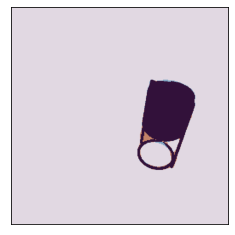

In [77]:
tdw_dataset.is_test = False
metrics = plot_errormap(net, tdw_dataset, ex=41, thresh=4, iters=24)

In [78]:
tdw_dataset.is_test = False
metrics = validate_examples(net, tdw_dataset, examples=None, thresh=4, iters=24)
agg_metrics(metrics)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 19/1250 [00:04<04:32,  4.51it/s]/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/home/dbear/tenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 1250/1250 [04:48<00:00,  4.33it/s]


({'iou': 0.8091718992953525,
  'precision': 0.9428615424043125,
  'recall': 0.8540110368232811},
 {'iou_isnan': 0.0512, 'precision_isnan': 0.1056, 'recall_isnan': 0.052})

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


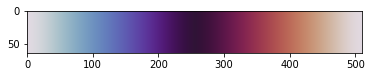

In [275]:
cmap = plt.cm.twilight(range(510))
cmap = np.stack([cmap]*64, 0)
plt.imshow(cmap)

In [67]:
bootraft.layers.num_parameters(net.module.update_block)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3120960

In [68]:
print(net.module.update_block)

BasicUpdateBlock(
  (encoder): BasicMotionEncoder(
    (convc1): Conv2d(324, 256, kernel_size=(1, 1), stride=(1, 1))
    (convc2): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (convf1): Conv2d(2, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (convf2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (gru): SepConvGRU(
    (convz1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convr1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convq1): Conv2d(384, 128, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (convz2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convr2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (convq2): Conv2d(384, 128, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
  )
  (flow_head): FlowHead(
    (conv1): C

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [120]:
tdw_dataset = raft_datasets.TdwFlowDataset(
    root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    dataset_names=['model_split_4'],    
    split='training',
    filepattern="*",
    test_filepattern="0*[0-4]",
    min_start_frame=0,
    max_start_frame=None,
    scale_to_pixels=True,
    get_gt_flow=True,
    training_frames='../datasets/supervision_frames/model_split_4_threshargmax.json',
    testing_frames='../datasets/supervision_frames/model_split_4_threshargmax.json'
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

1250
False


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
list(tdw_dataset.training_frames.values())[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[4], [9], [14], [21], [11], [4], [48], [15], [11], [52]]

In [112]:
list(tdw_dataset.testing_frames.values())[:10]

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[4], [9], [14], [21], [11], [44], [7], [14], [119], [6]]

In [122]:
data_blob = tdw_dataset[5]

selected frame 4


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
